In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
# Configurations

n_3b = 250000
n_all4b = 250000
seed = 62

In [40]:
import pathlib
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

from events_data import EventsData


directory = pathlib.Path("../events/MG3")
path_df_3b = directory / "dataframes" / f"threeTag_picoAOD_{n_3b}_{seed}.h5"
if pathlib.Path(path_df_3b).exists():
    df_3b = pd.read_hdf(path_df_3b)
else:
    df_3b = pd.read_hdf(directory / "dataframes" / "threeTag_picoAOD.h5")
    df_3b = df_3b.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_3b = df_3b.iloc[:n_3b]
    df_3b.to_hdf(path_df_3b, key="df", mode="w")

path_df_bg4b = directory / "dataframes" / f"fourTag_10x_picoAOD_{n_all4b}_{seed}.h5"
if pathlib.Path(path_df_bg4b).exists():
    df_bg4b = pd.read_hdf(path_df_bg4b)
else:
    df_bg4b = pd.read_hdf(directory / "dataframes" / "fourTag_10x_picoAOD.h5")
    df_bg4b = df_bg4b.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_bg4b = df_bg4b.iloc[:n_all4b]
    df_bg4b.to_hdf(
        path_df_bg4b,
        key="df",
        mode="w",
    )

path_df_signal = directory / "dataframes" / f"HH4b_picoAOD_{n_all4b}_{seed}.h5"
if pathlib.Path(path_df_signal).exists():
    df_signal = pd.read_hdf(path_df_signal)
else:
    df_signal = pd.read_hdf(directory / "dataframes" / "HH4b_picoAOD.h5")
    df_signal = df_signal.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_signal = df_signal.iloc[:n_all4b]
    df_signal.to_hdf(path_df_signal, key="df", mode="w")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_signal["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_signal))


features = [
    "sym_Jet0_pt",
    "sym_Jet1_pt",
    "sym_Jet2_pt",
    "sym_Jet3_pt",
    "sym_Jet0_eta",
    "sym_Jet1_eta",
    "sym_Jet2_eta",
    "sym_Jet3_eta",
    "sym_Jet0_phi",
    "sym_Jet1_phi",
    "sym_Jet2_phi",
    "sym_Jet3_phi",
    "sym_Jet0_m",
    "sym_Jet1_m",
    "sym_Jet2_m",
    "sym_Jet3_m",
]

3b-jet events:  250000
4b-jet events:  250000
HH4b-jet events:  30856


In [41]:
signal_ratio = 0.02
four_tag_ratio = 0.5
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
batch_size = 1024
val_ratio = 0.33
test_ratio = 0.5

In [42]:
pl.seed_everything(seed)
np.random.seed(seed)

events_3b = EventsData.from_dataframe(df_3b, features)
events_3b.shuffle(seed=seed)

events_bg4b = EventsData.from_dataframe(df_bg4b, features)
events_bg4b.shuffle(seed=seed)
events_bg4b.trim(n_all4b - int(n_all4b * signal_ratio))

events_signal = EventsData.from_dataframe(df_signal, features)
events_signal.shuffle(seed=seed)
events_signal.trim(int(n_all4b * signal_ratio))

# set weight ratio to be exactly signal ratio
new_hh4b_weights = (
    (signal_ratio / (1 - signal_ratio))
    * (events_bg4b.total_weight / events_signal.total_weight)
    * events_signal.weights
)
events_signal.reweight(new_hh4b_weights)

# set four tag ratio to be exactly four_tag_ratio

new_3b_weights = (
    (four_tag_ratio / (1 - four_tag_ratio))
    * (
        (events_bg4b.total_weight + events_signal.total_weight)
        / events_3b.total_weight
    )
    * events_3b.weights
)
events_3b.reweight(new_3b_weights)

events_train = EventsData.merge([events_3b, events_bg4b, events_signal])

# reduce number of 4b samples to 1/8
print(
    "4b ratio: ",
    events_train.total_weight_4b / events_train.total_weight,
)
print(
    "Signal ratio: ",
    events_train.total_weight_signal / events_train.total_weight_4b,
)

print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_test = events_train.split(
    1 - test_ratio, name_1="fvt_train", name_2="fvt_test", seed=seed
)
print(len(events_train))
events_train.shuffle(seed=seed)
events_train, events_val = events_train.split(
    0.67, name_1="fvt_train", name_2="fvt_val", seed=seed
)
print(len(events_train))
print(events_train.total_weight_4b / events_train.total_weight)
print(events_val.total_weight_4b / events_val.total_weight)
print(events_test.total_weight_4b / events_test.total_weight)

events_train.fit_batch_size(batch_size)
events_val.fit_batch_size(batch_size)

Seed set to 62


4b ratio:  0.5
Signal ratio:  0.019999998
500000
250000
167500
0.4990162
0.49978474
0.5007301


# Test dataset (Not validation dataset)

In [43]:
print("Test Data")
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
lr = 1e-3
run_name = "_".join(
    [
        "fvt_picoAOD",
        f"signal_ratio={signal_ratio}",
        f"four_tag_ratio={four_tag_ratio}",
        f"dijet={dim_dijet_features}",
        f"quadjet={dim_quadjet_features}",
        f"n_3b={n_3b}",
        f"n_all4b={n_all4b}",
        f"epochs={max_epochs}",
        f"batch_size={batch_size}",
        f"val_ratio={val_ratio}",
        f"test_ratio={test_ratio}",
        f"seed={seed}",
    ]
)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
fvt_model.eval()
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

events_test.set_model_scores(fvt_model)

logits = fvt_model(events_train.X_torch.to(device))
loss = fvt_model.loss(logits, events_train.is_4b_torch.to(device)).detach().cpu()
train_loss = ((events_train.weights_torch * loss).sum() / events_train.weights_torch.sum()).numpy()

logits = fvt_model(events_val.X_torch.to(device))
loss = fvt_model.loss(logits, events_val.is_4b_torch.to(device)).detach().cpu()
val_loss = ((events_val.weights_torch * loss).sum() / events_val.weights_torch.sum()).numpy()

logits = fvt_model(events_test.X_torch.to(device))
loss = fvt_model.loss(logits, events_test.is_4b_torch.to(device)).detach().cpu()
test_loss = ((events_test.weights_torch * loss).sum() / events_test.weights_torch.sum()).numpy()

print("Train loss: ", train_loss)
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

print("Train weights: ", events_train.total_weight_signal / events_train.total_weight)
print("Val weights: ", events_val.total_weight_signal / events_val.total_weight)
print("Test weights: ", events_test.total_weight_signal / events_test.total_weight)

Test Data
Train loss:  0.6566834
Val loss:  0.65802956
Test loss:  0.6588529
Train weights:  0.009742798
Val weights:  0.010298261
Test weights:  0.010067902


In [44]:
# test_losses = []
# val_losses = []
# train_losses = []
# test_srs = []
# val_srs = []
# train_srs = []
# test_4b_ratios = []
# val_4b_ratios = []
# train_4b_ratios = []

# sr_list = np.arange(0, 11) * 0.01
# for sr in sr_list:
#     run_name_2 = "_".join(
#     [
#         "fvt_picoAOD",
#         f"signal_ratio={sr}",
#         f"four_tag_ratio={four_tag_ratio}",
#         f"dijet={dim_dijet_features}",
#         f"quadjet={dim_quadjet_features}",
#         f"n_3b={n_3b}",
#         f"n_all4b={n_all4b}",
#         f"epochs={max_epochs}",
#         f"batch_size={batch_size}",
#         f"val_ratio={val_ratio}",
#         f"test_ratio={test_ratio}",
#         f"seed={seed}",
#     ]
# )


#     fvt_model_2 = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name_2}_best.ckpt")
#     fvt_model_2.eval()

#     logits = fvt_model_2(events_train.X_torch.to(device))
#     loss = fvt_model_2.loss(logits, events_train.is_4b_torch.to(device)).detach().cpu()
#     train_losses.append(((events_train.weights_torch * loss).sum() / events_train.weights_torch.sum()).numpy())

#     logits = fvt_model_2(events_val.X_torch.to(device))
#     loss = fvt_model_2.loss(logits, events_val.is_4b_torch.to(device)).detach().cpu()
#     val_losses.append(((events_val.weights_torch * loss).sum() / events_val.weights_torch.sum()).numpy())
    
#     logits = fvt_model_2(events_test.X_torch.to(device))
#     loss = fvt_model_2.loss(logits, events_test.is_4b_torch.to(device)).detach().cpu()
#     test_losses.append(((events_test.weights_torch * loss).sum() / events_test.weights_torch.sum()).numpy())

#     train_srs.append(events_train.total_weight_signal / events_train.total_weight_4b)
#     val_srs.append(events_val.total_weight_signal / events_val.total_weight_4b)
#     test_srs.append(events_test.total_weight_signal / events_test.total_weight_4b)

#     train_4b_ratios.append(events_train.total_weight_4b / events_train.total_weight)
#     val_4b_ratios.append(events_val.total_weight_4b / events_val.total_weight)
#     test_4b_ratios.append(events_test.total_weight_4b / events_test.total_weight)


# print("Train signal ratio: {}".format(events_train.total_weight_signal / events_train.total_weight_4b))
# print("Val signal ratio: {}".format(events_val.total_weight_signal / events_val.total_weight_4b))
# print("Test signal ratio: {}".format(events_test.total_weight_signal / events_test.total_weight_4b))
# plt.plot(sr_list, train_losses, label="train", marker="o")
# plt.plot(sr_list, val_losses, label="val", marker="o")
# plt.plot(sr_list, test_losses, label="test", marker="o")
# plt.legend()
# plt.show()

# plt.plot(sr_list, train_srs, label="train", marker="o")
# plt.plot(sr_list, val_srs, label="val", marker="o")
# plt.plot(sr_list, test_srs, label="test", marker="o")
# plt.legend()
# plt.show()
# plt.close()

# plt.plot(sr_list, train_4b_ratios, label="train", marker="o")
# plt.plot(sr_list, val_4b_ratios, label="val", marker="o")
# plt.plot(sr_list, test_4b_ratios, label="test", marker="o")
# plt.legend()
# plt.show()
# plt.close()

**Test Data**


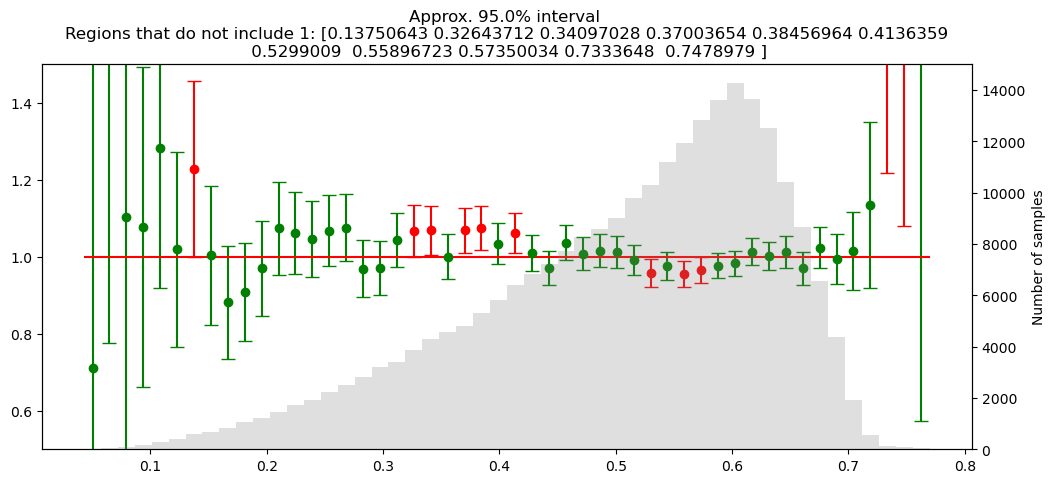

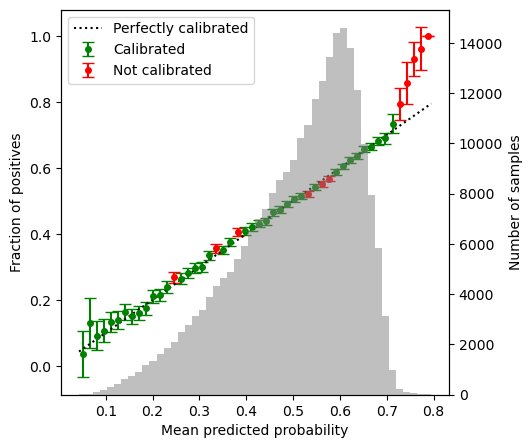

In [45]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


plot_prob_weighted_histogram1d(events_test.fvt_score, 
                               events_test.fvt_score, 
                               events_test.is_4b,
                               n_bins=50, 
                               sample_weights=events_test.weights,
                               ylim=(0.5, 1.5))
calibration_plot(events_test.fvt_score, events_test.is_4b,
                 bins=50,
                 sample_weights=events_test.weights)

/tmp/ipykernel_3302109/1964186131.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])


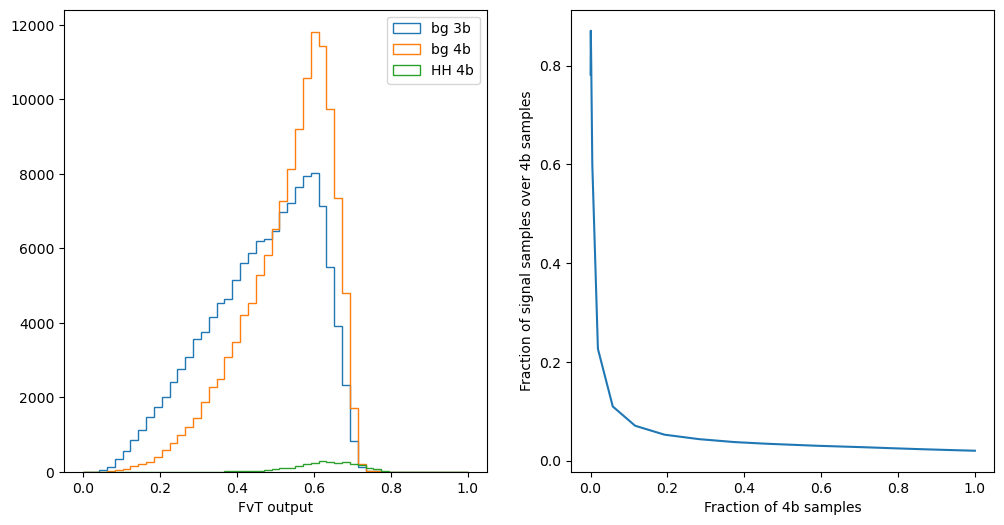

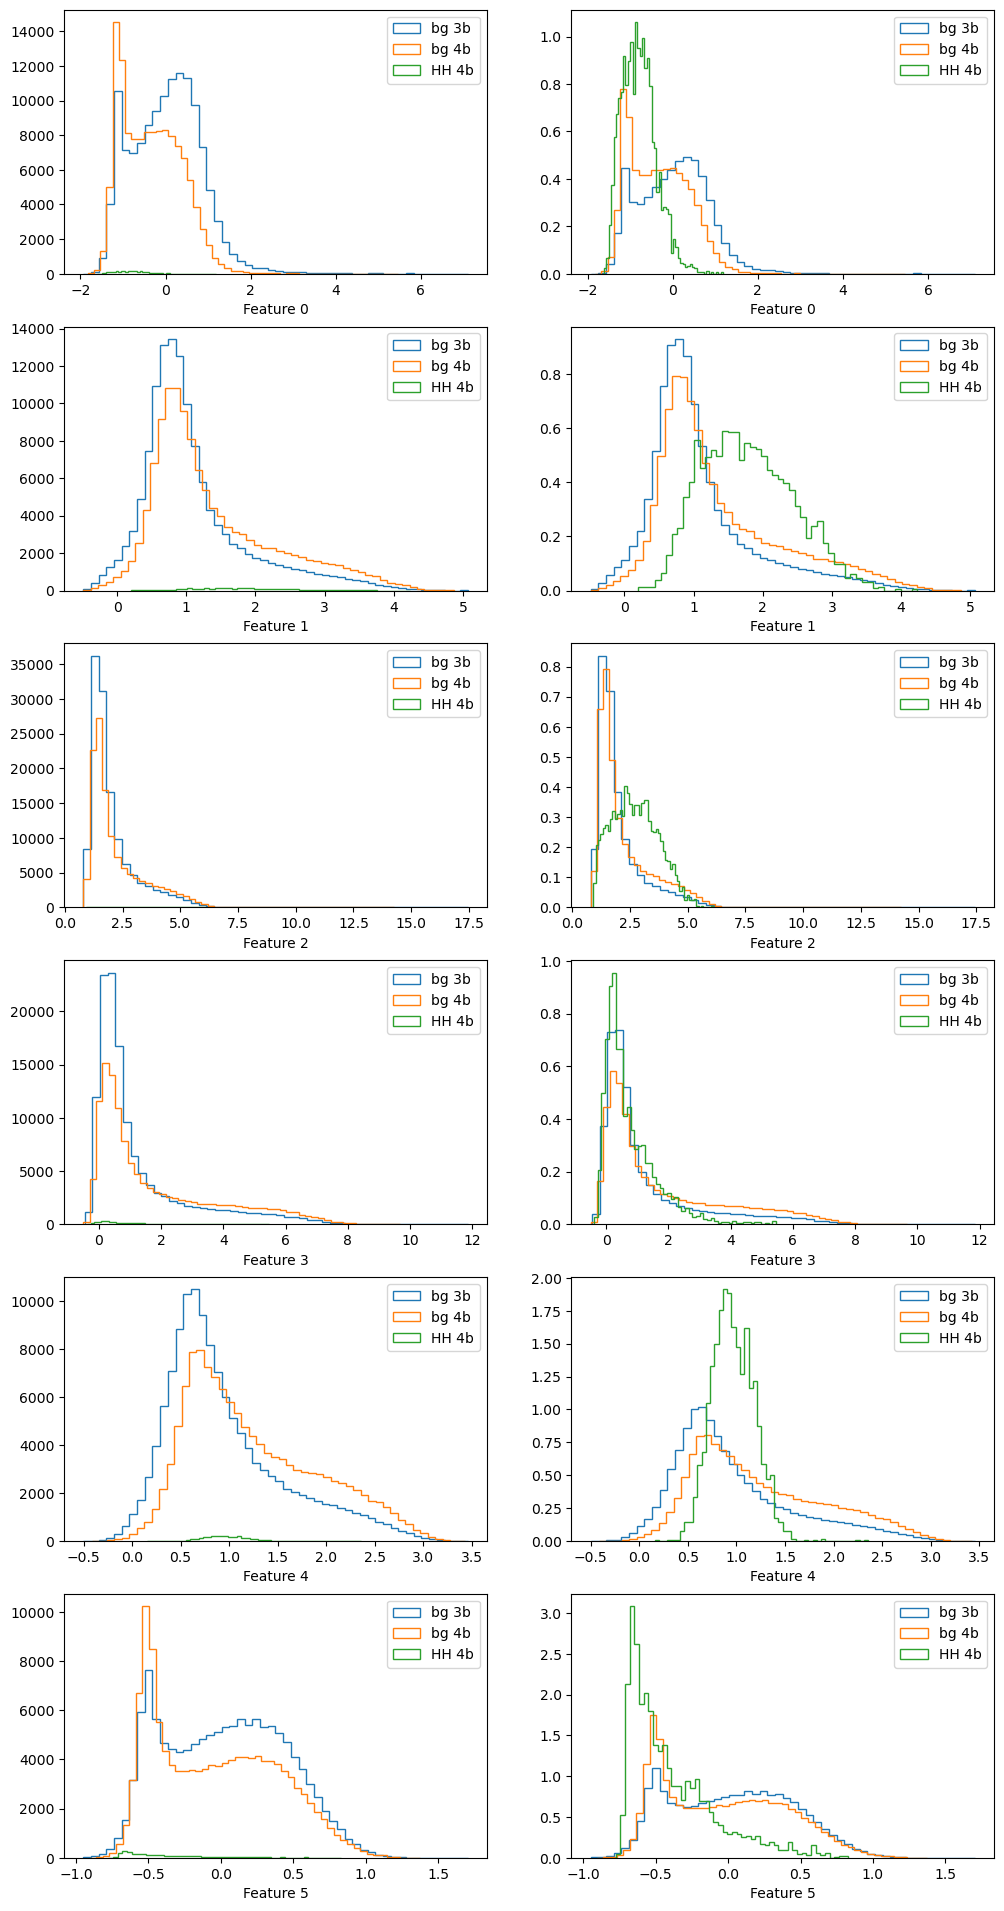

In [46]:
import matplotlib.pyplot as plt

# Pair plots with prob4b threshold

is_3b_test, is_bg4b_test, is_signal_test = events_test.is_3b, events_test.is_bg4b, events_test.is_signal
is_4b_test, w_test = events_test.is_4b, events_test.weights
fvt_score_test = events_test.fvt_score
att_q_repr_test = events_test.att_q_repr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

bins_range = np.linspace(0, 1, 50)
hist_3b, _, _ = ax[0].hist(fvt_score_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
hist_bg4b, _, _ = ax[0].hist(fvt_score_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
hist_signal, _, _ = ax[0].hist(fvt_score_test[is_signal_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
ax[0].legend()
ax[0].set_xlabel("FvT output")

ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])
ratio_signal_fvt_cut = ratio_signal_fvt_cut[::-1]
ratio_4b_samples_fvt_cut = np.cumsum(hist_bg4b[::-1] + hist_signal[::-1]) / np.sum(hist_bg4b + hist_signal)
ratio_4b_samples_fvt_cut = ratio_4b_samples_fvt_cut[::-1]

ax[1].plot(ratio_4b_samples_fvt_cut, ratio_signal_fvt_cut, label="Signal / all 4b")
ax[1].set_xlabel("Fraction of 4b samples")
ax[1].set_ylabel("Fraction of signal samples over 4b samples")

plt.show()
plt.close()

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_signal_test])
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=w_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_test[is_signal_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_signal_test])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()



/tmp/ipykernel_3302109/1127396710.py:17: RuntimeWarning: invalid value encountered in divide
  ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])
/tmp/ipykernel_3302109/1127396710.py:37: RuntimeWarning: divide by zero encountered in divide
  ax[2].stairs(hist_bg4b / hist_3b, bins_range, label="bg 4b / bg 3b", color="red")
/tmp/ipykernel_3302109/1127396710.py:37: RuntimeWarning: invalid value encountered in divide
  ax[2].stairs(hist_bg4b / hist_3b, bins_range, label="bg 4b / bg 3b", color="red")
/tmp/ipykernel_3302109/1127396710.py:38: RuntimeWarning: divide by zero encountered in divide
  ax[2].twinx().stairs(hist_signal / hist_3b, bins_range, label="HH 4b / bg 3b", color="blue")
/tmp/ipykernel_3302109/1127396710.py:38: RuntimeWarning: invalid value encountered in divide
  ax[2].twinx().stairs(hist_signal / hist_3b, bins_range, label="HH 4b / bg 3b", color="blue")


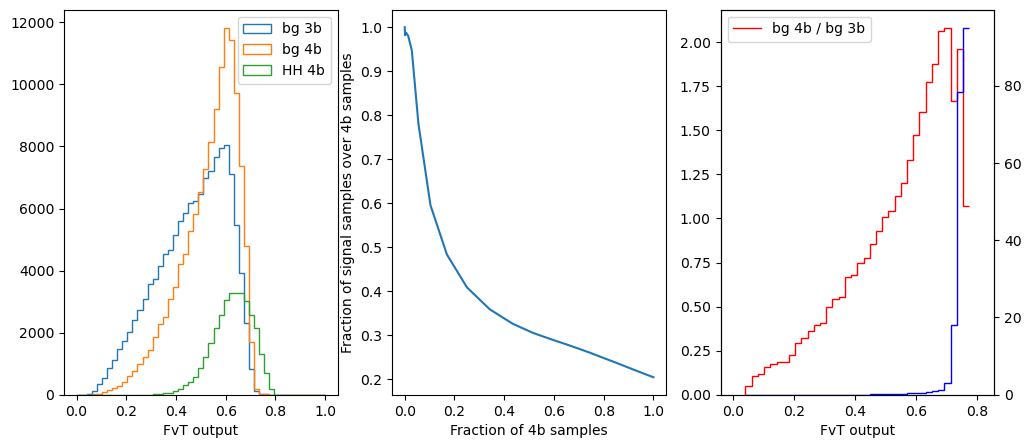

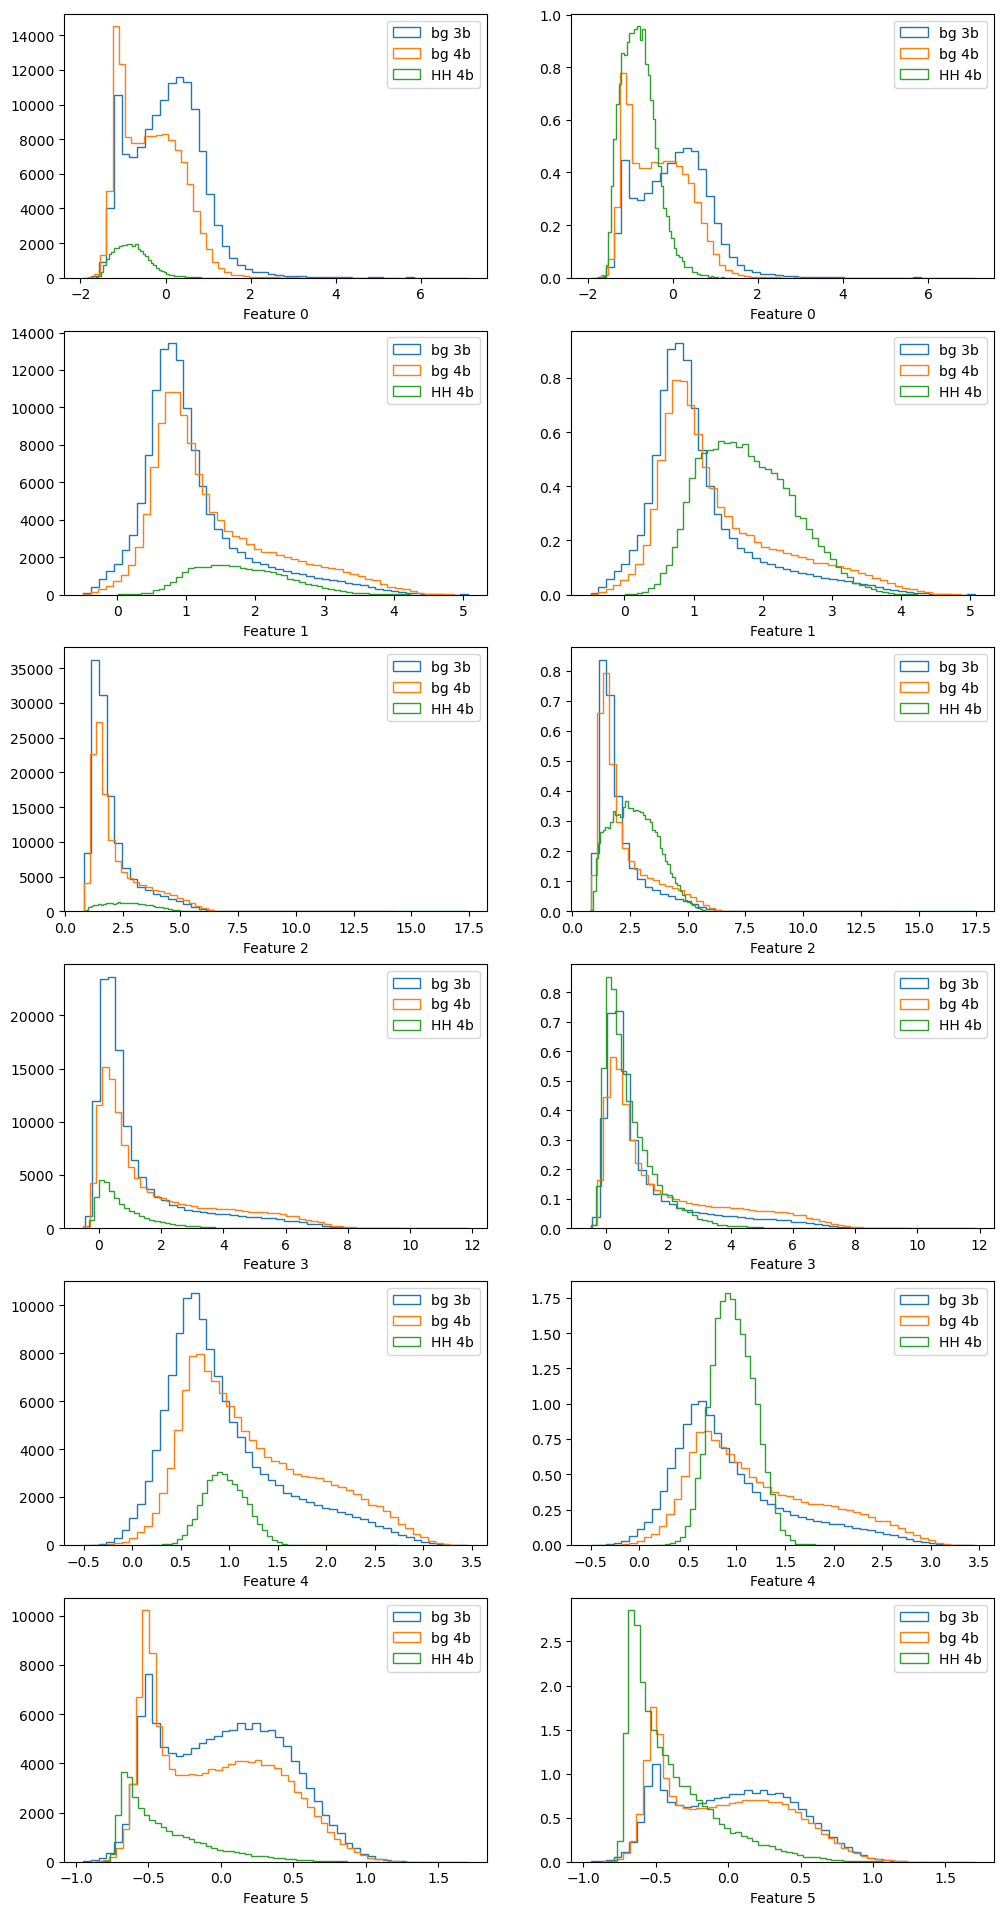

In [47]:
events_hh4b_all = EventsData.from_dataframe(df_signal, features)
events_hh4b_all.set_model_scores(fvt_model)
att_q_repr_hh4b = events_hh4b_all.att_q_repr
w_hh4b_all = events_hh4b_all.weights

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

bins_range = np.linspace(0, 1, 50)
hist_3b, _, _ = ax[0].hist(fvt_score_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
hist_bg4b, _, _ = ax[0].hist(fvt_score_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
hist_signal, _, _ = ax[0].hist(events_hh4b_all.fvt_score, bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_hh4b_all)
ax[0].legend()
ax[0].set_xlabel("FvT output")

ratio_signal_fvt_cut = np.cumsum(hist_signal[::-1]) / np.cumsum(hist_bg4b[::-1] + hist_signal[::-1])
ratio_signal_fvt_cut = ratio_signal_fvt_cut[::-1]
ratio_4b_samples_fvt_cut = np.cumsum(hist_bg4b[::-1] + hist_signal[::-1]) / np.sum(hist_bg4b + hist_signal)
ratio_4b_samples_fvt_cut = ratio_4b_samples_fvt_cut[::-1]
ratio_all_samples_fvt_cut = np.cumsum(hist_3b[::-1] + hist_bg4b[::-1] + hist_signal[::-1]) / np.sum(hist_3b + hist_bg4b + hist_signal)
ratio_all_samples_fvt_cut = ratio_all_samples_fvt_cut[::-1]
ratio_signal_samples_fvt_cut = np.cumsum(hist_signal[::-1]) / np.sum(hist_signal)
ratio_signal_samples_fvt_cut = ratio_signal_samples_fvt_cut[::-1]

ax[1].plot(ratio_4b_samples_fvt_cut, ratio_signal_fvt_cut, label="Signal / all 4b")
ax[1].set_xlabel("Fraction of 4b samples")
ax[1].set_ylabel("Fraction of signal samples over 4b samples")


# ax[2].plot(ratio_all_samples_fvt_cut, ratio_signal_samples_fvt_cut, label="Signal / all 4b")
# ax[2].plot([0, 1], [0, 1], "--", color="black")
# ax[2].set_xlabel("Fraction of 4b samples")
# ax[2].set_ylabel("Fraction of all samples")
# ax[2].grid(axis="both")

ax[2].stairs(hist_bg4b / hist_3b, bins_range, label="bg 4b / bg 3b", color="red")
ax[2].twinx().stairs(hist_signal / hist_3b, bins_range, label="HH 4b / bg 3b", color="blue")
ax[2].legend()
ax[2].set_xlabel("FvT output")


plt.show()
plt.close()

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_hh4b[:, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_hh4b_all)
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=w_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_hh4b[:, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=w_hh4b_all)
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()



In [48]:
events_hh4b_some = EventsData.from_dataframe(df_signal, features)
events_hh4b_some.shuffle()
events_hh4b_some.trim(int(np.sum(events_test.is_4b) * 0.02))

events_more_hh4b = EventsData.merge([events_test[~events_test.is_signal], events_hh4b_some])
events_more_hh4b.shuffle()
events_more_hh4b.set_model_scores(fvt_model)

In [49]:
from signal_region import get_fvt_cut_regions
from plots import plot_cluster

fvt_cut = 0.0
w_cuts = np.arange(0.01, 1.01, 0.01)
is_in_regions_list, reducer = get_fvt_cut_regions(events_more_hh4b, fvt_cut=fvt_cut, w_cuts=w_cuts, seed=seed,
                                                 return_reducer=True, reducer_args={"random_state": seed}, 
                                                 init_bins=10000, max_bins=50)

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Thresholded 4b clustering
bg4b:  122677
signal:  2503


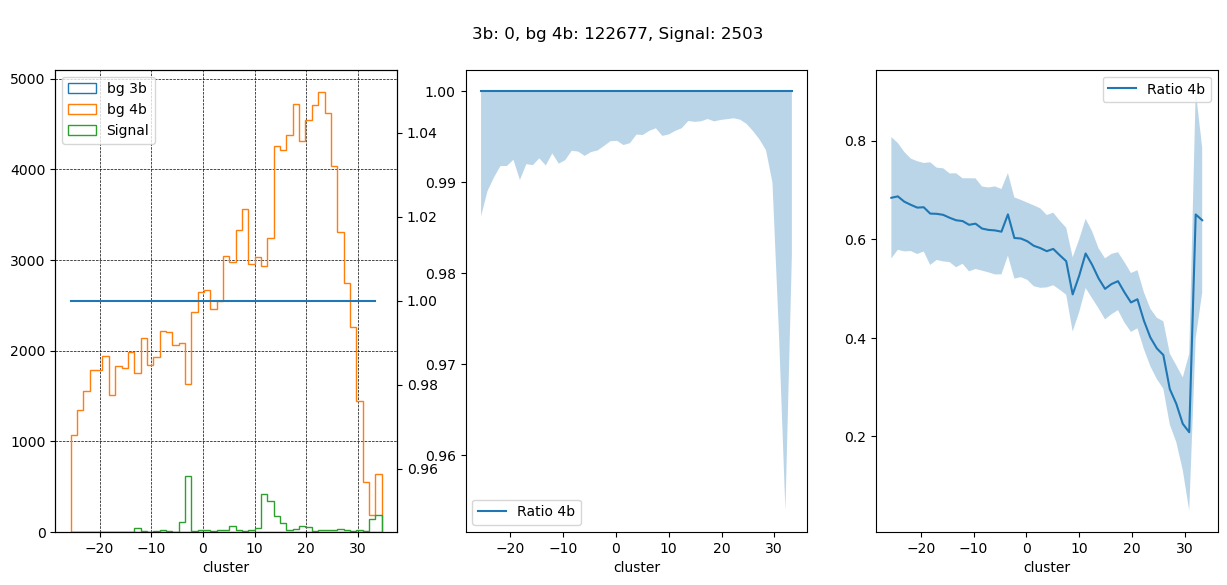

Thresholded samples
3b:  124810
bg4b:  122677
hh4b:  2503


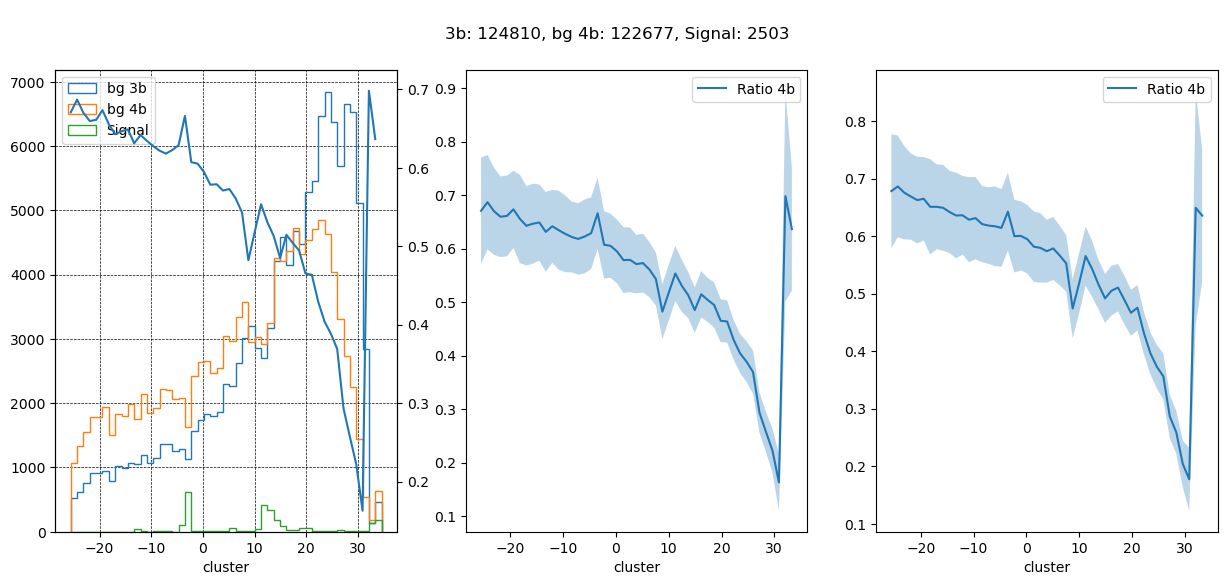

No samples exceeded threshold
All samples
3b:  124810
bg4b:  122677
hh4b:  2503


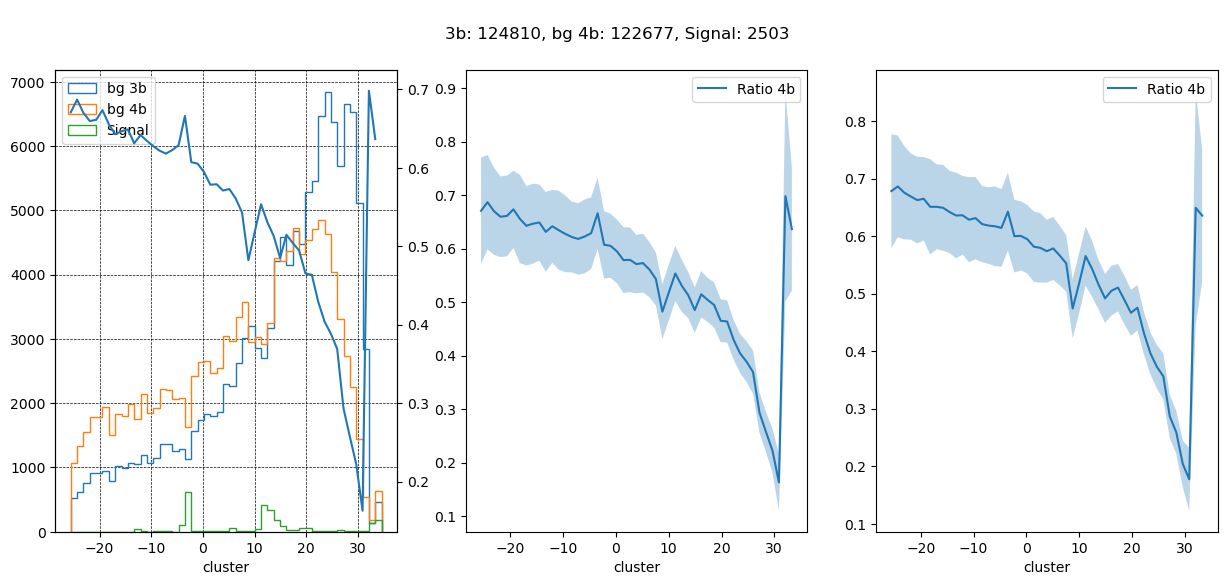

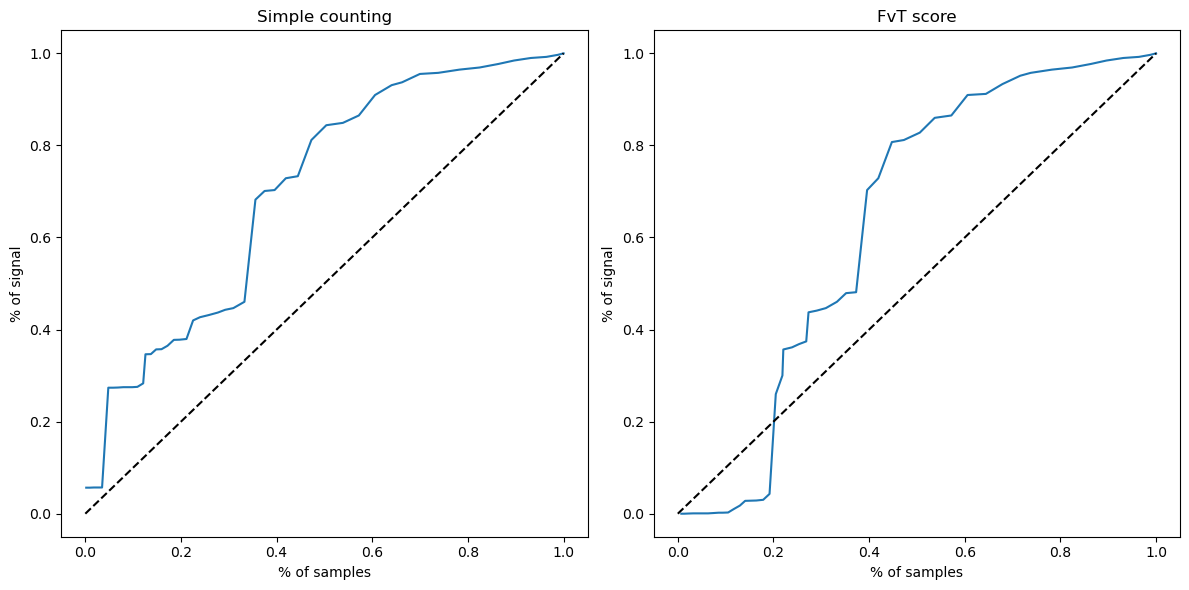

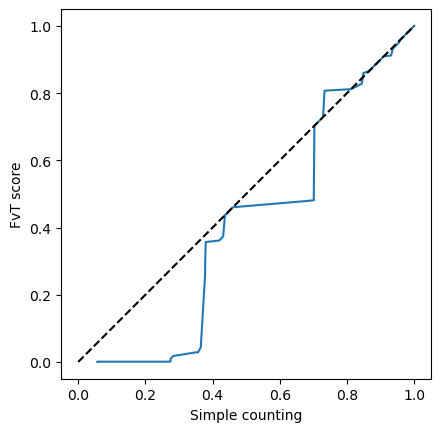

In [50]:
n_components = 1
fvt_exceeded = events_more_hh4b.fvt_score > fvt_cut

np.random.seed(seed)
cluster_samples = fvt_exceeded & events_more_hh4b.is_4b
events_cluster = events_more_hh4b[cluster_samples]

# print number of points in each class
print("Thresholded 4b clustering")
print("bg4b: ", np.sum(events_cluster.is_bg4b))
print("signal: ", np.sum(events_cluster.is_signal))

cluster_repr_test = events_cluster.npd["cluster_embed"]
plot_cluster(cluster_repr_test, events_cluster, n_components=n_components)


# Thresholded samples

print("Thresholded samples")
print("3b: ", np.sum(events_more_hh4b.is_3b & fvt_exceeded))
print("bg4b: ", np.sum(events_more_hh4b.is_bg4b & fvt_exceeded))
print("hh4b: ", np.sum(events_more_hh4b.is_signal & fvt_exceeded))

thrsed_samples = fvt_exceeded
events_thrsed = events_more_hh4b[thrsed_samples]
cluster_repr_thrsed = events_thrsed.npd["cluster_embed"]

plot_cluster(cluster_repr_thrsed, events_thrsed, n_components=n_components)

# Failed samples

if not np.any(~fvt_exceeded):
    print("No samples exceeded threshold")
else:
    print("Failed samples")
    print("3b: ", np.sum(events_more_hh4b.is_3b & ~fvt_exceeded))
    print("bg4b: ", np.sum(events_more_hh4b.is_bg4b & ~fvt_exceeded))
    print("hh4b: ", np.sum(events_more_hh4b.is_signal & ~fvt_exceeded))

    failed_samples = ~fvt_exceeded
    events_failed = events_more_hh4b[failed_samples]
    cluster_repr_failed = events_failed.npd["cluster_embed"]

    plot_cluster(cluster_repr_failed, events_failed, n_components=n_components)

# all samples

print("All samples")
print("3b: ", np.sum(events_more_hh4b.is_3b))
print("bg4b: ", np.sum(events_more_hh4b.is_bg4b))
print("hh4b: ", np.sum(events_more_hh4b.is_signal))

all_samples = np.ones(len(events_more_hh4b), dtype=bool)
events_all = events_more_hh4b[all_samples]
cluster_repr_all = events_all.npd["cluster_embed"]

plot_cluster(cluster_repr_all, events_all, n_components=n_components)


n_bins = 50
cluster_embed_more_hh4b = events_more_hh4b.npd["cluster_embed"].reshape(-1)
bins_range = np.linspace(np.min(cluster_embed_more_hh4b), 
                         np.max(cluster_embed_more_hh4b), n_bins + 1)

hist_3b, _ = np.histogram(cluster_embed_more_hh4b[events_more_hh4b.is_3b], 
                          bins=bins_range, weights=events_more_hh4b.weights[events_more_hh4b.is_3b])
hist_bg4b, _ = np.histogram(cluster_embed_more_hh4b[events_more_hh4b.is_bg4b], 
                            bins=bins_range, weights=events_more_hh4b.weights[events_more_hh4b.is_bg4b])
hist_signal, _ = np.histogram(cluster_embed_more_hh4b[events_more_hh4b.is_signal], 
                              bins=bins_range, weights=events_more_hh4b.weights[events_more_hh4b.is_signal])
hist_all = hist_3b + hist_bg4b + hist_signal
hist_4b = hist_bg4b + hist_signal

ratio_4b_cnt = hist_4b / hist_all
ratio_4b_fvt = np.zeros_like(ratio_4b_cnt)
for i in range(len(ratio_4b_fvt)):
    weights_bin = np.sum(
        events_more_hh4b.weights[(cluster_embed_more_hh4b > bins_range[i]) 
               & (cluster_embed_more_hh4b < bins_range[i + 1])])
    fvt_score_sum = np.sum(
        events_more_hh4b.fvt_score[(cluster_embed_more_hh4b > bins_range[i]) 
                              & (cluster_embed_more_hh4b < bins_range[i + 1])])
    ratio_4b_fvt[i] = fvt_score_sum / weights_bin

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# sort by ratio_4b_cnt and plot hist_3b, hist_bg4b, hist_signal

sort_idx_cnt = np.argsort(ratio_4b_cnt)[::-1]
# ax[0].stairs(np.cumsum(hist_3b[sort_idx_cnt]), np.arange(n_bins + 1), label="bg 3b")
# ax[0].stairs(np.cumsum(hist_bg4b[sort_idx_cnt]), np.arange(n_bins + 1), label="bg 4b")
# twin_ax = ax[0].twinx()
ax[0].plot(np.cumsum(hist_all[sort_idx_cnt]) / np.sum(hist_all), 
           np.cumsum(hist_signal[sort_idx_cnt]) / np.sum(hist_signal))
ax[0].plot([0, 1], [0, 1], linestyle="--", color="black")
ax[0].set_xlabel("% of samples")
ax[0].set_ylabel("% of signal")
ax[0].set_title("Simple counting")

sort_idx_fvt = np.argsort(ratio_4b_fvt)[::-1]
# ax[1].stairs(np.cumsum(hist_3b[sort_idx_fvt]), np.arange(n_bins + 1), label="bg 3b")
# ax[1].stairs(np.cumsum(hist_bg4b[sort_idx_fvt]), np.arange(n_bins + 1), label="bg 4b")
# twin_ax = ax[1].twinx()
ax[1].plot(np.cumsum(hist_all[sort_idx_fvt]) / np.sum(hist_all), 
           np.cumsum(hist_signal[sort_idx_fvt]) / np.sum(hist_signal))    
ax[1].plot([0, 1], [0, 1], linestyle="--", color="black")
ax[1].set_xlabel("% of samples")
ax[1].set_ylabel("% of signal")
ax[1].set_title("FvT score")

plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots()

ax.plot(np.cumsum(hist_signal[sort_idx_cnt]) / np.sum(hist_signal), 
         np.cumsum(hist_signal[sort_idx_fvt]) / np.sum(hist_signal))
ax.plot([0, 1], [0, 1], linestyle="--", color="black")
ax.set_xlabel("Simple counting")
ax.set_ylabel("FvT score")
ax.set_aspect("equal")
plt.show()
plt.close()